# Creates scatter plots for PIPS data relative to radar

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
import matplotlib.colors as colors
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import matplotlib.colors as colors
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# from natsort import natsorted
from pprint import pprint

def remove_unneeded(ds):
    dim_names_to_remove = ['fields_KHTX', 'fields_KGWX', 'fields', 'gridded_fields_KGWX']
    ds = ds.drop_dims(dim_names_to_remove, errors='ignore')
    return ds
#

PIPS_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
# parsivel_filenames = glob.glob(PIPS_dir + '/parsivel_combined*60s*nc')
# parsivel_ds_read = xr.open_mfdataset(parsivel_filenames, combine='nested', concat_dim='time',
#                                      preprocess=pipsio.remove_unneeded) #, combine='nested', concat_dim='time')
deployment_name = 'IOP4C_D1_2016'
parsivel_filenames = glob.glob(PIPS_dir + '/parsivel_combined_{}*nc'.format(deployment_name))
parsivel_ds_read_dict = {}

for parsivel_filename in parsivel_filenames:
    parsivel_ds_read = xr.load_dataset(parsivel_filename)
    parsivel_ds_read_dict[parsivel_ds_read.probe_name] = parsivel_ds_read

In [3]:
ND_tag = '_qc'
ND_retr_tag = '_qc'
dD = pp.parsivel_parameters['max_diameter_bins_mm'] - pp.parsivel_parameters['min_diameter_bins_mm']

probe_names = []
for probe_name, parsivel_ds_read in parsivel_ds_read_dict.items():
    probe_names.append(probe_name)

if 'retr' in ND_tag:
    for probe_name in probe_names:
        parsivel_ds_read = parsivel_ds_read_dict[probe_name]
        parsivel_ds_read['rainrate_derived{}'.format(ND_tag)] = parsivel_ds_read['RR{}'.format(ND_tag)]
        parsivel_ds_read_dict[probe_name] = parsivel_ds_read

# Filter entire dataset on rainrate > 0.1 and compute some derived radar variables for the PIPS using the
# requested ND
parsivel_ds_dict = {}
for probe_name, parsivel_ds_read in parsivel_ds_read_dict.items():    
    parsivel_ds = parsivel_ds_read.where(parsivel_ds_read['rainrate_derived{}'.format(ND_tag)] > 0.1)
    ND = parsivel_ds['ND{}'.format(ND_tag)]
    dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                      ND, dD)
    ZH = dualpol_dict['ZH']
    ZDR = dualpol_dict['ZDR']
    parsivel_ds['dBZ'] = dualpol_dict['REF']
    parsivel_ds['ZH'] = ZH
    parsivel_ds['ZDR'] = ZDR
    # Filter on ZDR > 0.1 for now (Guifu's retrieval code uses their own emperical fits for ZDR < 0.1, so we need
    # to compute our own since we get weird artifacts using theirs)
    parsivel_ds = parsivel_ds.where(ZDR > 0.1)
    parsivel_ds_dict[probe_name] = parsivel_ds# 

In [4]:
radar_name = 'KGWX'
gridded_radar = False
if gridded_radar:
    radar_field_prefix = 'gridded_fields_{}'.format(radar_name)
    radar_prefix = 'gridded_{}'.format(radar_name)
    ZH_field_name = 'reflectivity_masked'
    ZDR_field_name = 'differential_reflectivity_masked'
else:
    radar_field_prefix = 'fields_{}'.format(radar_name)
    radar_prefix = '{}'.format(radar_name)
    ZH_field_name = 'REF_filtered'
    ZDR_field_name = 'ZDR_filtered'
PIPS_name = 'PIPS1B'
PIPS_to_drop = 'PIPS1A'
# Drop PIPS if needed
parsivel_list = [v for k, v in parsivel_ds_dict.items() if k not in PIPS_to_drop]
# parsivel_ds = xr.concat(parsivel_list, dim='time')
# Or... Just look at one PIPS
parsivel_ds = parsivel_ds_dict[PIPS_name]
print(parsivel_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KGWX: 65, gridded_fields_KGWX: 69, parameter: 3, time: 61)
Coordinates: (12/20)
  * time                                 (time) datetime64[ns] 2016-04-30T20:...
    fallspeed                            (fallspeed_bin) float64 0.05 ... 20.8
    diameter                             (diameter_bin) float64 0.0625 ... 24.5
    min_diameter                         (diameter_bin) float64 0.0 ... 23.0
    max_diameter                         (diameter_bin) float64 0.125 ... 26.0
    min_fallspeeds                       (fallspeed_bin) float64 0.0 ... 19.2
    ...                                   ...
    y                                    float64 7.638e+04
    x                                    float64 8.651e+04
    alt                                  float64 2.179e+03
    time_seconds                         (time) float64 4.751e+03 ... nan
    lat                                  float

In [5]:
print(parsivel_ds['{}_beam_height_at_PIPS'.format(radar_name)].max())
# print(parsivel_ds)
# parsivel_ds['reflectivity_derived{}'.format(ND_tag)].plot()

<xarray.DataArray 'KGWX_beam_height_at_PIPS' ()>
array(1704.89904021)
Coordinates:
    z        float64 2e+03
    y        float64 7.638e+04
    x        float64 8.651e+04
    alt      float64 2.179e+03
    lat      float64 34.58
    lon      float64 -87.4


In [6]:
ND = parsivel_ds['ND{}'.format(ND_tag)]
# print(ND['min_diameter'])
# dD = pp.parsivel_parameters['max_diameter_bins_mm'] - pp.parsivel_parameters['min_diameter_bins_mm']
# dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
#                                   ND, dD)
# ZH = dualpol_dict['ZH']
# ZDR = dualpol_dict['ZDR']
ZH = parsivel_ds['ZH']
ZDR = parsivel_ds['ZDR']
rho = parsivel_ds['rho']
W_obs, _ = dsd.calc_lwc_qr_from_bins(ND, rho)
W_obs = W_obs * 1000.
if 'retr' in ND_tag:
    factor = 1.
else:
    factor = 1000.
Dm_obs = parsivel_ds['Dm43{}'.format(ND_tag)] * factor
sigma_obs = parsivel_ds['sigma{}'.format(ND_tag)] * factor
D0_obs = dsd.calc_D0_bin(ND.load()) * factor
for retr_name in ['SATP_TMM246', 'C08', 'Z01', 'TMM246_F']:
    ND_retr = parsivel_ds['ND_retr_{}{}'.format(retr_name, ND_retr_tag)]
    parsivel_ds['D0_retr_{}{}'.format(retr_name, ND_retr_tag)] = dsd.calc_D0_bin(ND_retr.load()) * 1000.
RR_obs = parsivel_ds['rainrate_derived{}'.format(ND_tag)]
Nt_obs = dsd.calc_NT_from_bins(parsivel_ds['ND{}'.format(ND_tag)])

rad_retr_dict = {}
for field in parsivel_ds[radar_field_prefix].values:
    print(field)
    rad_retr_dict[field] = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel(
        {
            radar_field_prefix: field
        })
    # TODO: recompute D0 from gamma distribution. ND_retr is not saved for radar fields...

    
#W_retr_SATP_rad = parsivel_ds['KGWX_at_PIPS'].sel(fields_KGWX=)
# mask everything at times with ZDR from radar < 0.1. Already did so for the PIPS-derived ZDR
parsivel_ds = parsivel_ds.where(parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel(
    {
        radar_field_prefix: ZDR_field_name
    }) > 0.1)
# Filter on ZH > 5 for the gridded radar to match what was done for the "raw" radar
# TODO: Need to do the same for RHV < 0.95... but don't have that in the gridded radar... sigh
parsivel_ds = parsivel_ds.where(parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel(
    {
        radar_field_prefix: ZH_field_name
    }) > 5.)

REF
VEL
SW
ZDR
PHI
RHO
REF_s3
REF_s5
REF_filtered
ZDR_filtered
RHO_filtered
D0_SATP
Dm_SATP
N0_SATP
Nt_SATP
RR_SATP
W_SATP
lamda_SATP
mu_SATP
sigma_SATP
D0_C08
Dm_C08
N0_C08
Nt_C08
RR_C08
W_C08
lamda_C08
mu_C08
sigma_C08
D0_Z01
Dm_Z01
N0_Z01
Nt_Z01
RR_Z01
W_Z01
lamda_Z01
mu_Z01
sigma_Z01
D0_TMM_F
Dm_TMM_F
N0_TMM_F
Nt_TMM_F
RR_TMM_F
W_TMM_F
lamda_TMM_F
mu_TMM_F
sigma_TMM_F
D0_SATP_RB15_qc
Dm_SATP_RB15_qc
N0_SATP_RB15_qc
Nt_SATP_RB15_qc
RR_SATP_RB15_qc
W_SATP_RB15_qc
lamda_SATP_RB15_qc
mu_SATP_RB15_qc
sigma_SATP_RB15_qc
D0_TMM_F_RB15_qc
Dm_TMM_F_RB15_qc
N0_TMM_F_RB15_qc
Nt_TMM_F_RB15_qc
RR_TMM_F_RB15_qc
W_TMM_F_RB15_qc
lamda_TMM_F_RB15_qc
mu_TMM_F_RB15_qc
sigma_TMM_F_RB15_qc


In [7]:
if gridded_radar:
    plot_dir = os.path.join(PIPS_dir, 'plots/scatter/gridded_radar_retrieval')
else:
    plot_dir = os.path.join(PIPS_dir, 'plots/scatter/radar_retrieval')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
figfmt = 'png'

retr_names = ['Z01', 'C08', 'TMM_F', 'SATP', 'TMM_F_RB15_qc', 'SATP_RB15_qc']
# retr_names = ['Z01', 'C08', 'TMM246_F_qc', 'SATP_TMM246_qc', 'TMM246_F_RB15_qc', 'SATP_TMM246_RB15_qc']
row_labels = ['Z01', 'C08', 'TMM246-F', 'SATP-TMM246', 'TMM246-F-RB15', 'SATP-TMM246-RB15']
titles = ['Z01', 'C08', 'TMM246 (filtered)', 'SATP', 'TMM246 (filtered, RB15)', 'SATP (RB15)']

def plot_radar_field_PIPS_one2one(radar_name, PIPS_name, var_obs, var_rad, col_field, title, axparams_var, 
                                  deployment_name='Unknown'):
    var_ds = xr.Dataset({'var_obs': var_obs, 'var_rad': var_rad, 'col_field': col_field})
    cc, bias = pips.calc_stats(var_ds, 'var_obs', 'var_rad')
    fig, ax = PIPSplot.plot_one2one(var_ds, 'var_obs', 'var_rad', axparams_var)
    ax.set_title(title)
    plot_filename = '{}_{}_one2one_{}_at_{}_ND{}.{}'.format(deployment_name, var_obs.name, radar_name, 
                                                            PIPS_name, ND_tag, figfmt)
    plot_path = os.path.join(plot_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')   
    return cc.iloc[0, 1], bias

def plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, rad_var_name, rad_retr_name, var_obs,
                                 ND_tag, col_field, title, axparams_var, deployment_name='Unknown', 
                                 gridded_radar=False):
    
    if gridded_radar:
        radar_field_prefix = 'gridded_fields_{}'.format(radar_name)
        radar_prefix = 'gridded_{}'.format(radar_name)
    else:
        radar_field_prefix = 'fields_{}'.format(radar_name)
        radar_prefix = radar_name
        
    var_retr = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel({
        radar_field_prefix: '{}_{}'.format(rad_var_name, rad_retr_name)
    })
    overlap = (var_obs > 0.) & (var_retr > 0.)
    var_obs_plt = var_obs.where(overlap)
    var_retr_plt = var_retr.where(overlap)
    var_ds = xr.Dataset({'var_obs': var_obs_plt, 'var_retr': var_retr_plt, 'col_field': col_field})
    cc, bias = pips.calc_stats(var_ds, 'var_obs', 'var_retr')
    fig, ax = PIPSplot.plot_one2one(var_ds, 'var_obs', 'var_retr', axparams_var)
    ax.set_title(title)
    plot_filename = '{}_{}_one2one_{}_at_{}_{}_ND{}.{}'.format(deployment_name, rad_var_name, radar_name, 
                                                               PIPS_name, rad_retr_name, ND_tag, figfmt)
    plot_path = os.path.join(plot_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    return cc.iloc[0, 1], bias

axparams = {
    'Dm': {
        'var_lims': [[0.5, 4.5], [0.5, 4.5]],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$D_m$ (obs; mm)',
        'label_y': r'$D_m$ (retrieved; mm)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'sigma': {
        'var_lims': [[0.5, 3.5], [0.5, 3.5]],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$D_m$ (obs; mm)',
        'label_y': r'$D_m$ (retrieved; mm)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'Nt': {
        'var_lims': [[0.0, 4.5], [0.0, 4.5]],
        'plot_log': [True, True],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$N_T$ (obs; #/m$^3$)',
        'label_y': r'$N_T$ (retrieved; #/m$^3$)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'RR': {
        'var_lims': [[0.0, 250.], [0.0, 250.]],
        'plot_log': [False, False],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$RR$ (obs; mm h$^{-1}$)',
        'label_y': r'$RR$ (retrieved; mm h$^{-1}$)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'D0': {
        'var_lims': [[0.5, 4.5], [0.5, 4.5]],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$D_0$ (obs; mm)',
        'label_y': r'$D_0$ (retrieved; mm)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'ZH': {
        'var_lims': [[0.0, 60.], [0.0, 60.]],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$Z_H$ (PIPS; dBZ)',
        'label_y': r'$Z_H$ (radar; dBZ)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    },
    'ZDR': {
        'var_lims': [[0.0, 3.], [0.0, 3.]],
        'col_field': 'col_field',
        'col_field_lims': [0.1, 200.],
        'norm': colors.LogNorm(vmin=0.1, vmax=200.),
        'alpha': 0.75,
        'markersize': 15,
        'label_x': r'$Z_{DR}$ (PIPS; dB)',
        'label_y': r'$Z_{DR}$ (radar; dB)',
        'label_cb': r'$RR$ (mm h$^{-1}$)'
    }
}

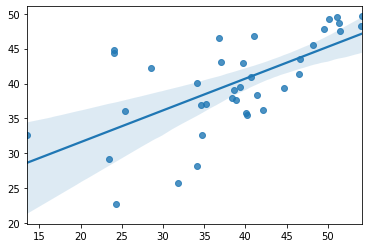

In [8]:
import seaborn as sns
ax = sns.regplot(x=parsivel_ds['dBZ'].values, y=rad_retr_dict[ZH_field_name].values)

In [9]:
var_PIPS_list = [parsivel_ds['dBZ'], parsivel_ds['ZDR']]
var_rad_list = [rad_retr_dict[ZH_field_name], rad_retr_dict[ZDR_field_name]]


In [10]:
# Compute statistics and generate latex table row strings for paper
var_PIPS_list = [Dm_obs, sigma_obs, RR_obs, D0_obs, Nt_obs]
rad_varname_list = ['Dm', 'sigma', 'RR', 'D0', 'Nt']

# Do some checks for names of retrieval variables because they could have been saved under different names


stats_dict = {}
for rad_retr_name, row_label in zip(retr_names, row_labels):
    cc_list = []
    bias_list = []
    for var_obs, rad_var_name in zip(var_PIPS_list, rad_varname_list):
        var_rad = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel({
            radar_field_prefix: '{}_{}'.format(rad_var_name, rad_retr_name)
        })
        overlap = (var_obs > 0.) & (var_rad > 0.)
        var_obs_overlap = var_obs.where(overlap)
        var_rad_overlap = var_rad.where(overlap)
        var_ds = xr.Dataset({'var_obs': var_obs_overlap, 'var_retr': var_rad_overlap})
        cc, bias = pips.calc_stats(var_ds, 'var_obs', 'var_retr')
        cc = cc.iloc[0, 1]
        bias = np.asscalar(bias)
        cc_list.append(cc)
        bias_list.append(bias)
        
#         print("CC, bias for {} and {}:".format(rad_var_name, rad_retr_name))
#         print("{:.2f}, {:.2f}".format(cc, bias))
    tuple_list = [(cc, bias) for cc, bias in zip(cc_list, bias_list)]
    stats_dict[rad_retr_name] = [x for y in tuple_list for x in y]
    if 'RB15' in ND_tag:
        retr_row_label = '{} (RB15)'.format(row_label)
    else:
        retr_row_label = row_label
    table_row = "{}".format(retr_row_label) + (5 * " & {:.2f} ({:.2f})").format(*stats_dict[rad_retr_name]) 
    print(table_row)

Z01 & 0.09 (0.51) & 0.46 (2.08) & 0.71 (0.76) & -0.09 (8.17) & 0.71 (17.92)
C08 & 0.06 (-4.07) & 0.43 (7.03) & 0.71 (5.54) & -0.10 (1.85) & 0.64 (159.19)
TMM246-F & 0.12 (-5.54) & 0.49 (3.97) & 0.69 (5.64) & -0.05 (-0.11) & 0.63 (64.06)
SATP-TMM246 & 0.12 (-6.70) & 0.49 (4.00) & 0.70 (6.82) & -0.05 (-1.50) & 0.61 (81.31)
TMM246-F-RB15 & 0.11 (3.83) & 0.47 (2.56) & 0.70 (-5.10) & -0.10 (11.28) & 0.62 (-21.90)
SATP-TMM246-RB15 & 0.12 (5.02) & 0.48 (3.53) & 0.69 (-7.97) & -0.07 (13.07) & 0.58 (-26.67)


cc = 0.65
bias = 3.72


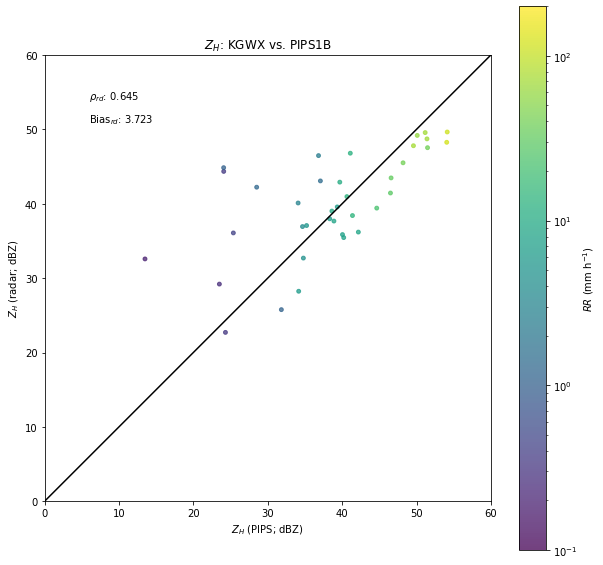

In [11]:
# PIPS_name = 'PIPS1B,2A,2B'
PIPS_name = 'PIPS1B'
# Plot Z one-to-one scatterplots
var_rad = rad_retr_dict[ZH_field_name]
var_PIPS = parsivel_ds['dBZ']
axparams_var = axparams['ZH']
title = r'$Z_H$: {} vs. {}'.format(radar_name, PIPS_name)

cc, bias = plot_radar_field_PIPS_one2one(radar_name, PIPS_name, var_PIPS, var_rad, RR_obs, title, axparams_var,
                                         deployment_name=deployment_name)
print("cc = {:.2f}".format(cc))
print("bias = {:.2f}".format(bias))

(0.4572116192261845, array(1.41143323))

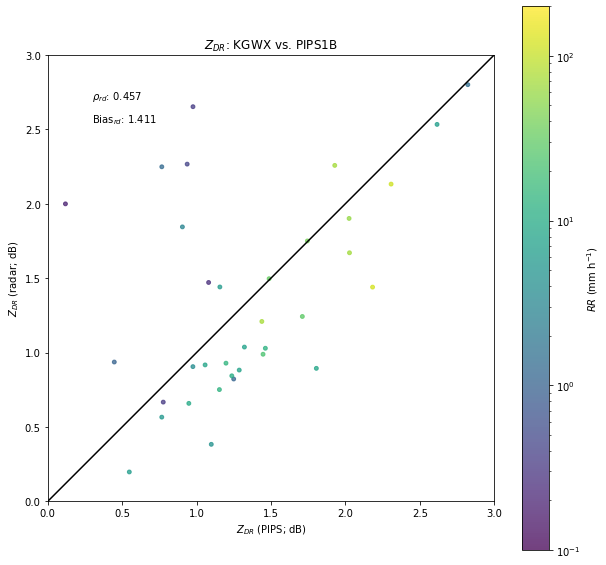

In [12]:
# Plot ZDR one-to-one scatterplots
var_rad = rad_retr_dict[ZDR_field_name]
var_PIPS = parsivel_ds['ZDR']
axparams_var = axparams['ZDR']
title = r'$Z_{{DR}}$: {} vs. {}'.format(radar_name, PIPS_name)

plot_radar_field_PIPS_one2one(radar_name, PIPS_name, var_PIPS, var_rad, RR_obs, title, axparams_var,
                              deployment_name=deployment_name)

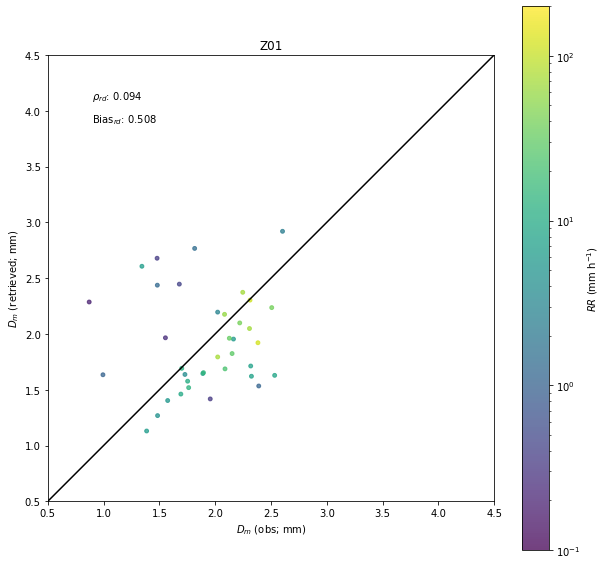

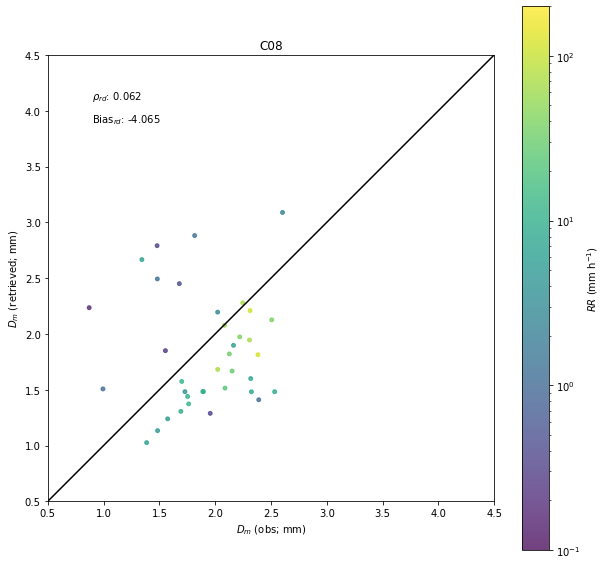

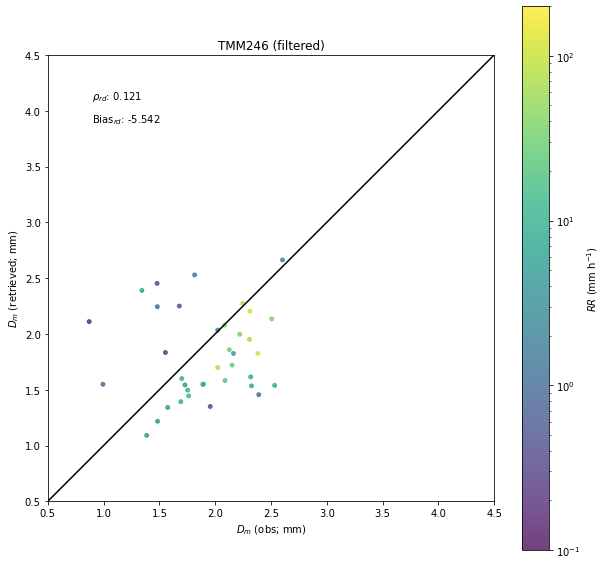

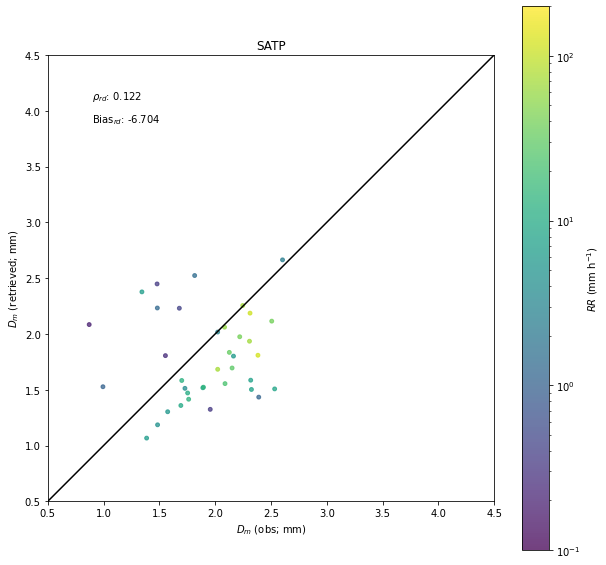

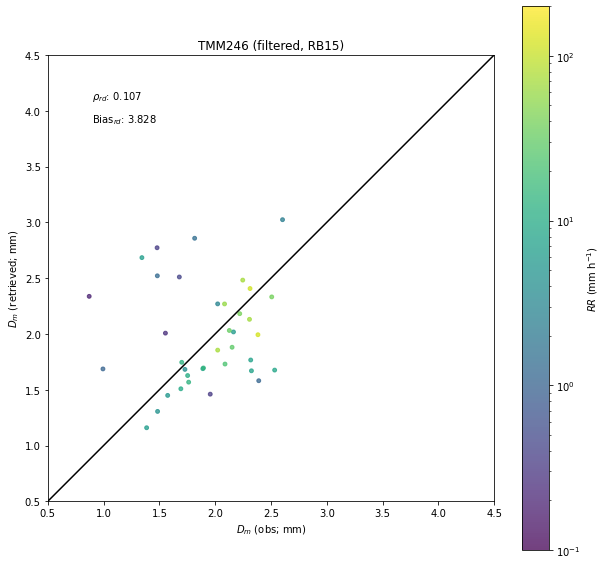

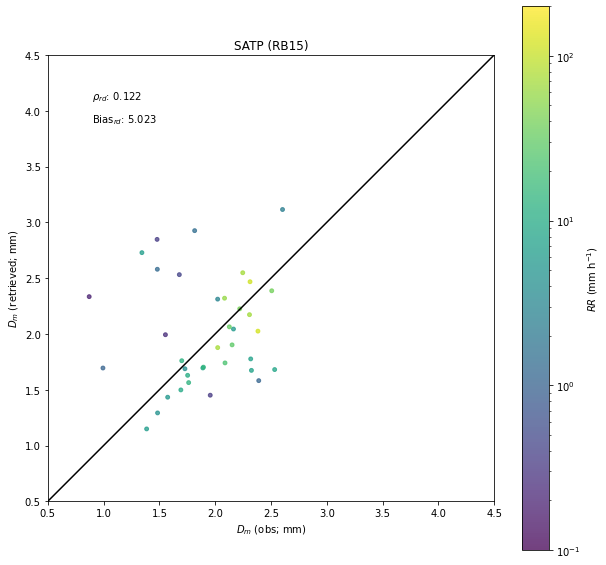

In [13]:
# Dm
varname = 'Dm'
var_obs = Dm_obs
col_field = RR_obs
axparams_var = axparams[varname]
for rad_retr_name, title in zip(retr_names, titles):
    plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, varname, rad_retr_name, var_obs, ND_tag, 
                                 col_field, title, axparams_var, deployment_name=deployment_name, 
                                 gridded_radar=gridded_radar)

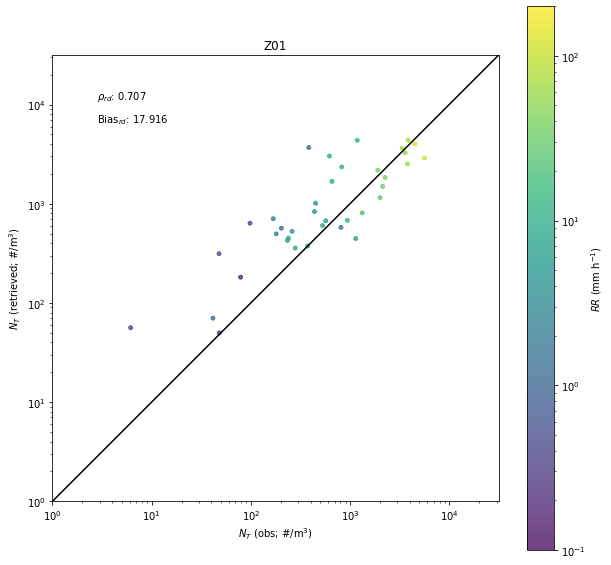

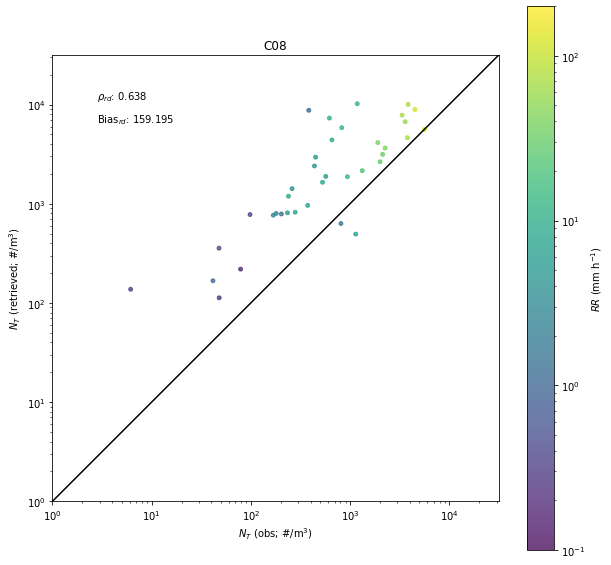

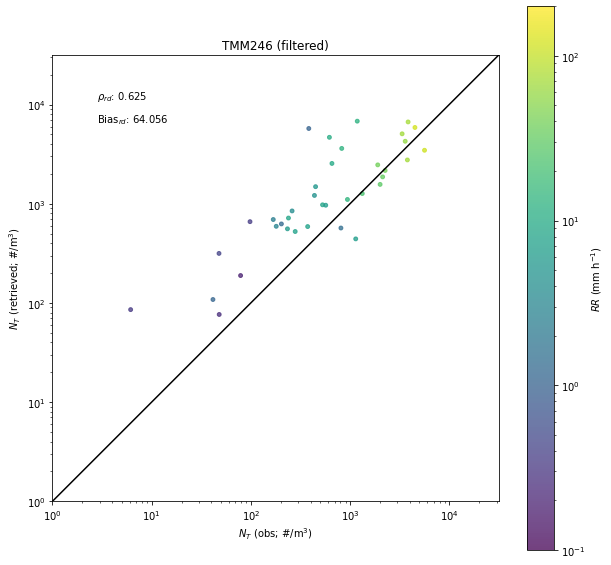

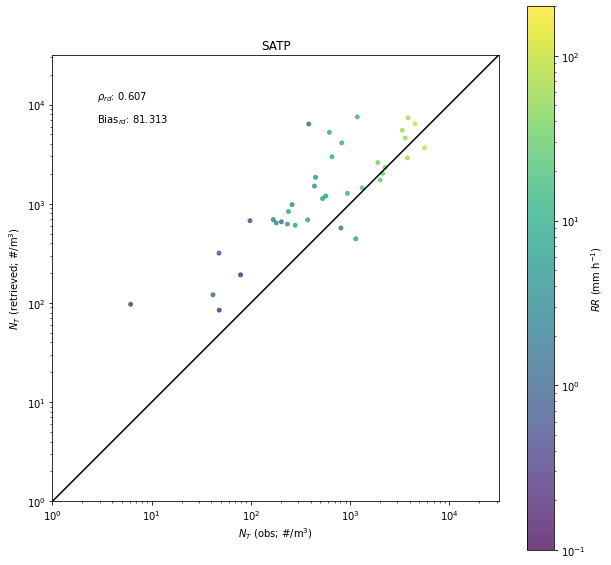

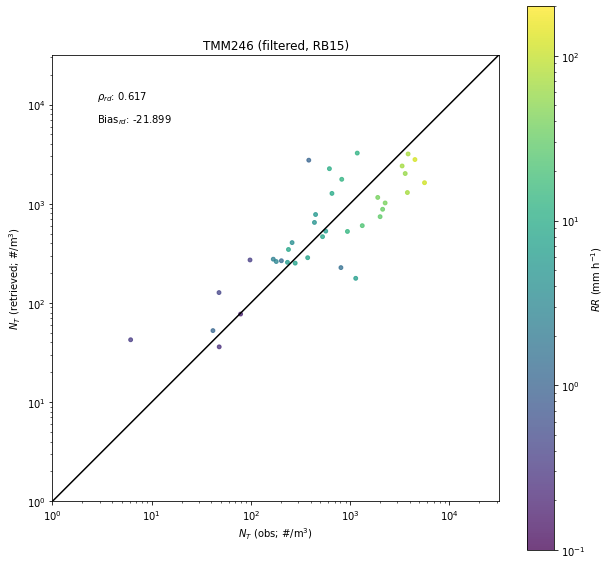

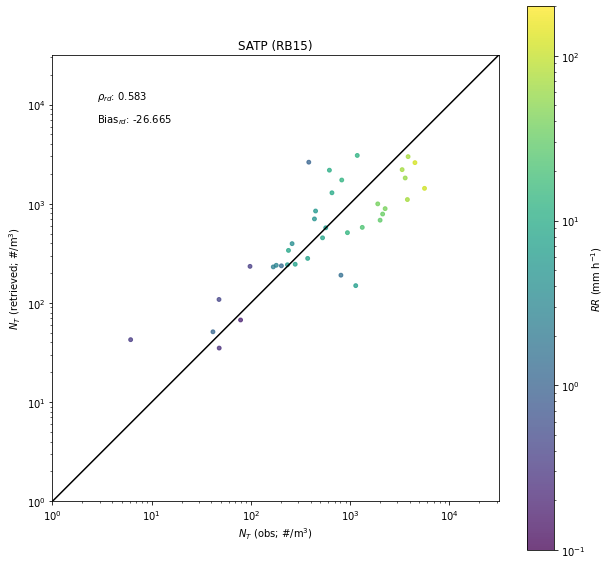

In [14]:
# Nt
varname = 'Nt'
var_obs = Nt_obs
col_field = RR_obs
axparams_var = axparams[varname]
for rad_retr_name, title in zip(retr_names, titles):
    plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, varname, rad_retr_name, var_obs, ND_tag, 
                                 col_field, title, axparams_var, deployment_name=deployment_name, 
                                 gridded_radar=gridded_radar)

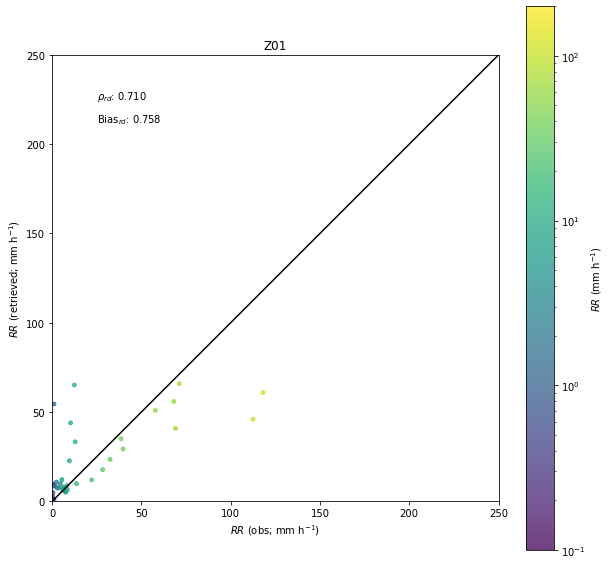

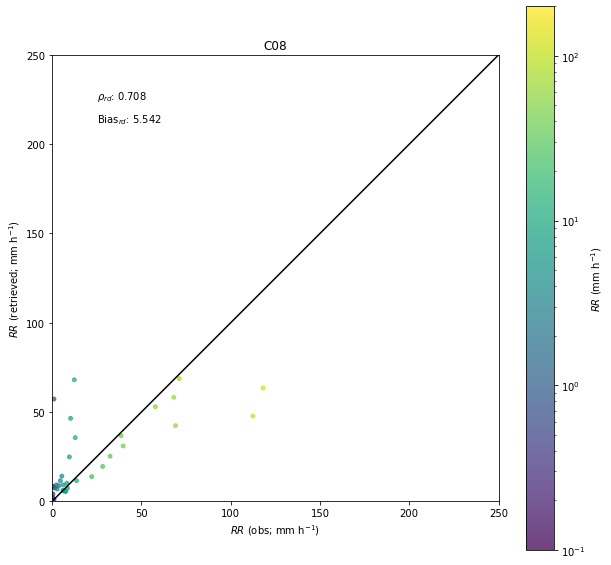

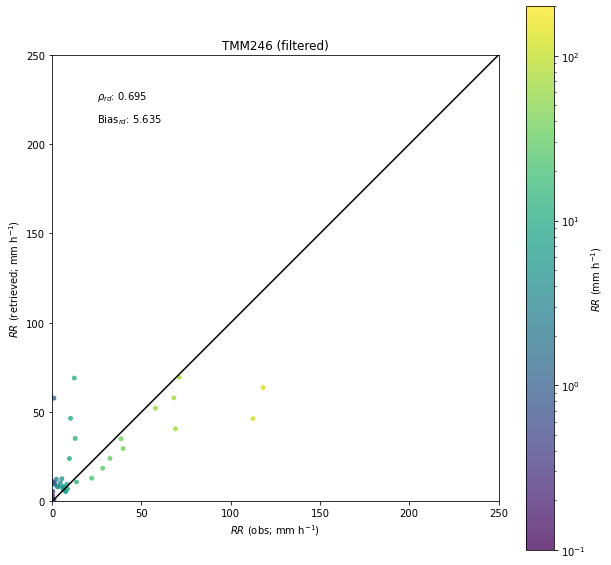

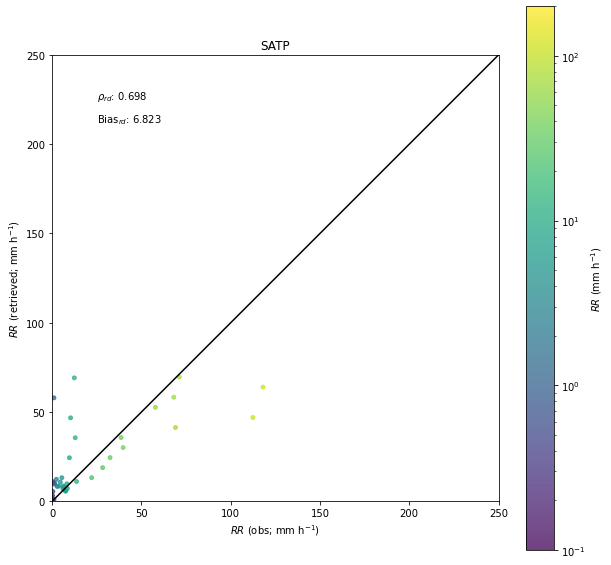

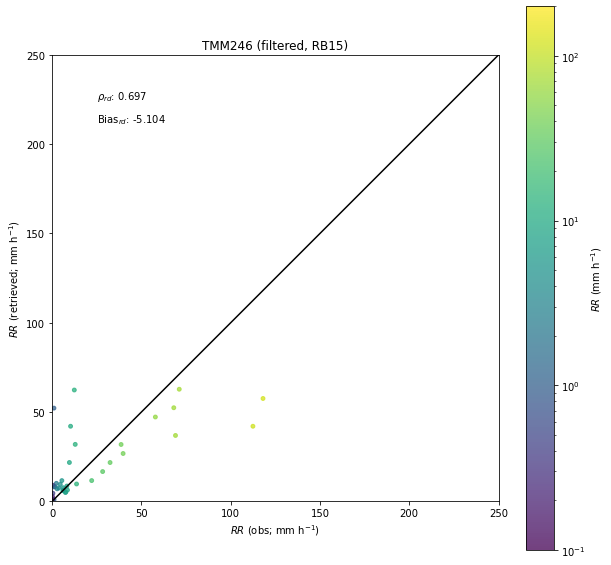

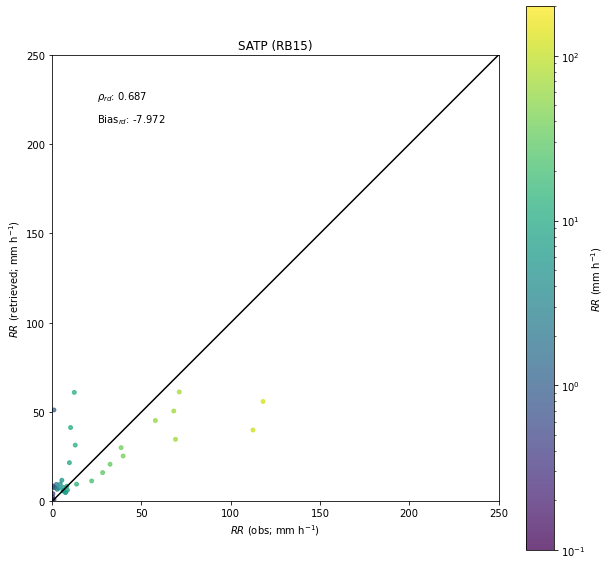

In [15]:
# RR
varname = 'RR'
var_obs = RR_obs
col_field = RR_obs
axparams_var = axparams[varname]
for rad_retr_name, title in zip(retr_names, titles):
    plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, varname, rad_retr_name, var_obs, ND_tag, 
                                 col_field, title, axparams_var, deployment_name=deployment_name, 
                                 gridded_radar=gridded_radar)

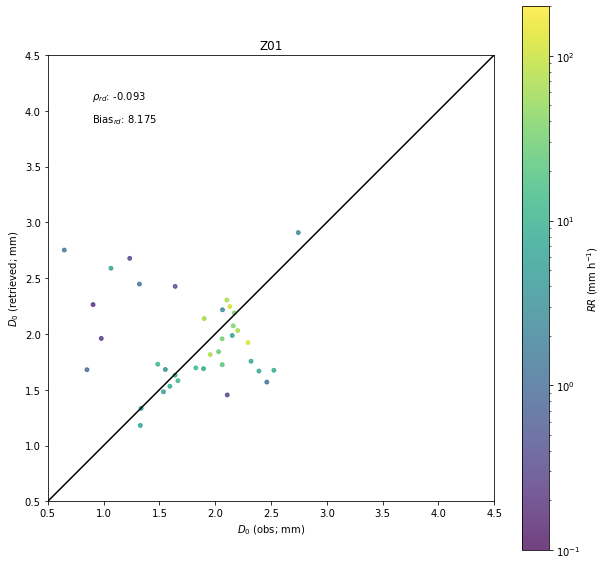

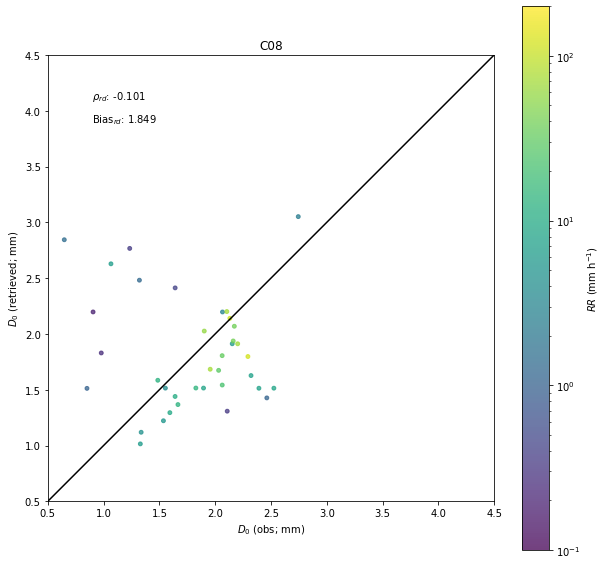

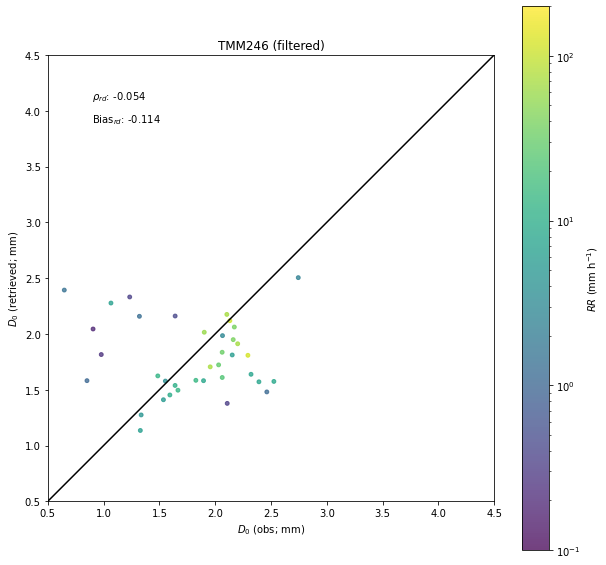

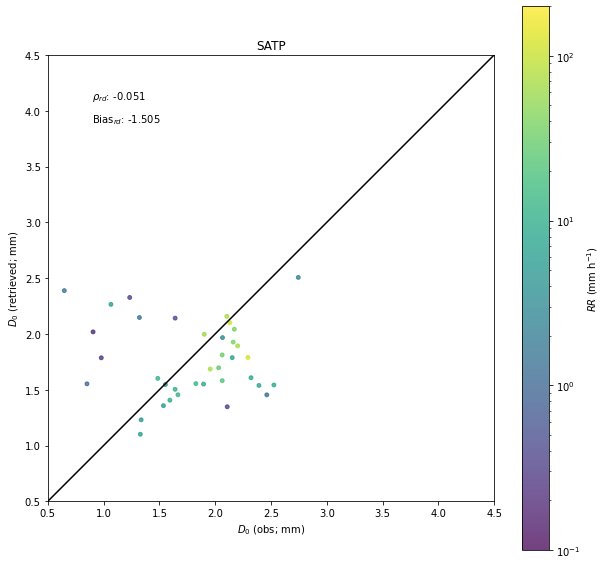

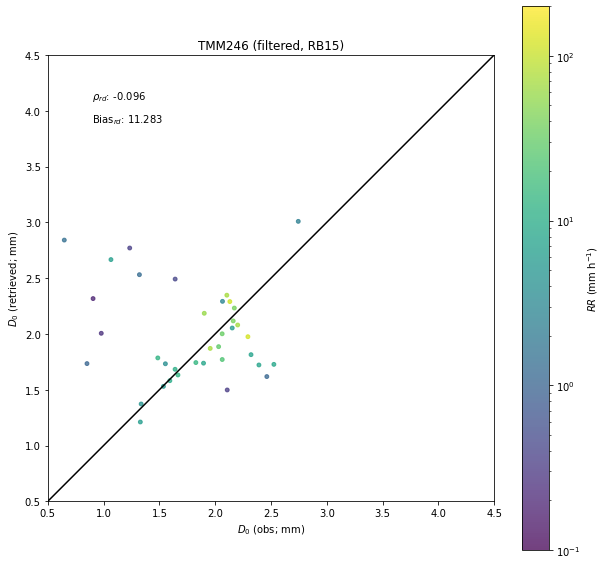

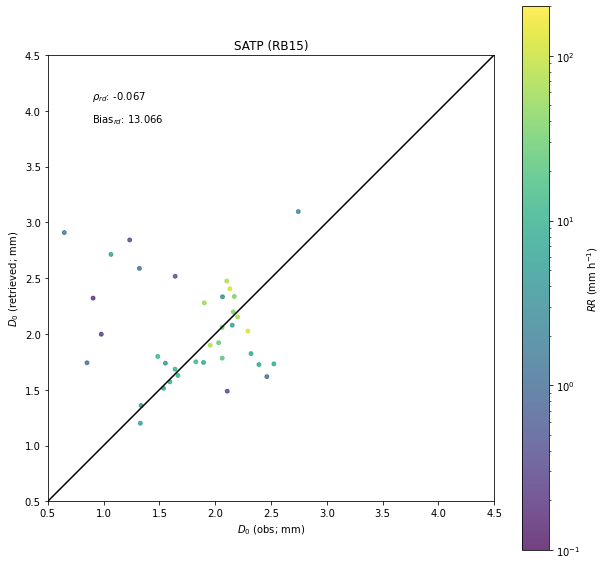

In [16]:
# D0
varname = 'D0'
var_obs = D0_obs
col_field = RR_obs
axparams_var = axparams[varname]
for rad_retr_name, title in zip(retr_names, titles):
    plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, varname, rad_retr_name, var_obs, ND_tag, 
                                 col_field, title, axparams_var, deployment_name=deployment_name, 
                                 gridded_radar=gridded_radar)

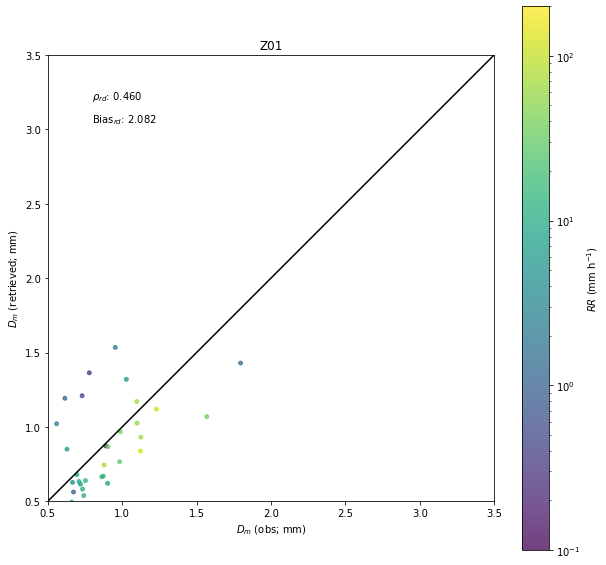

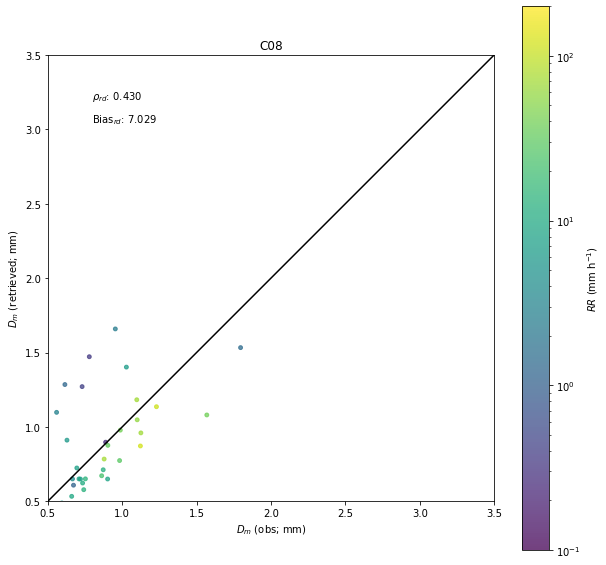

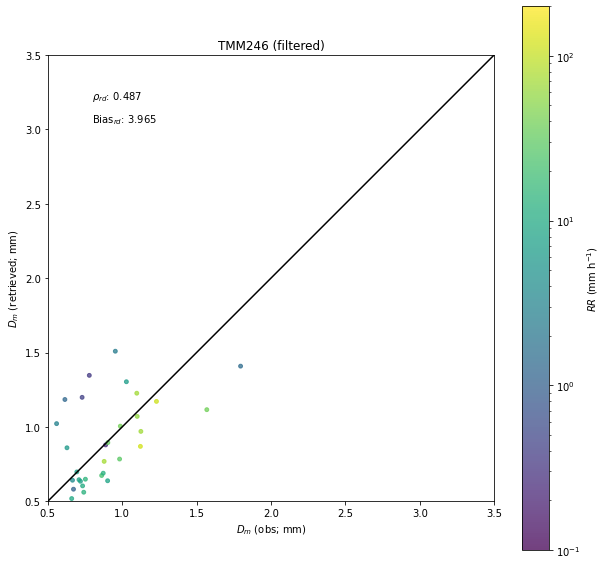

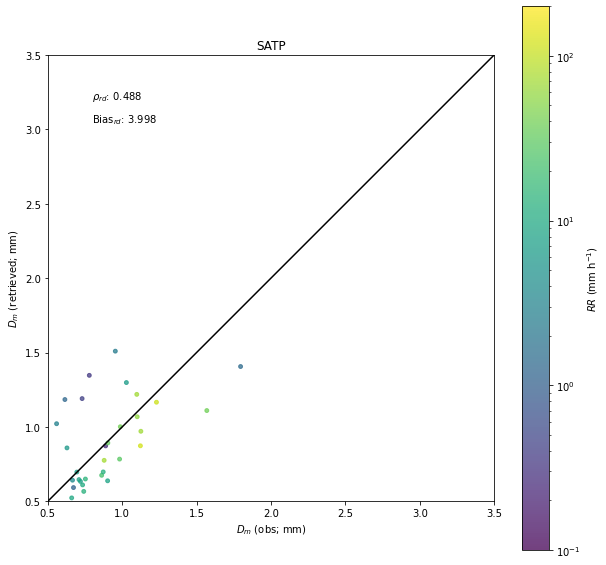

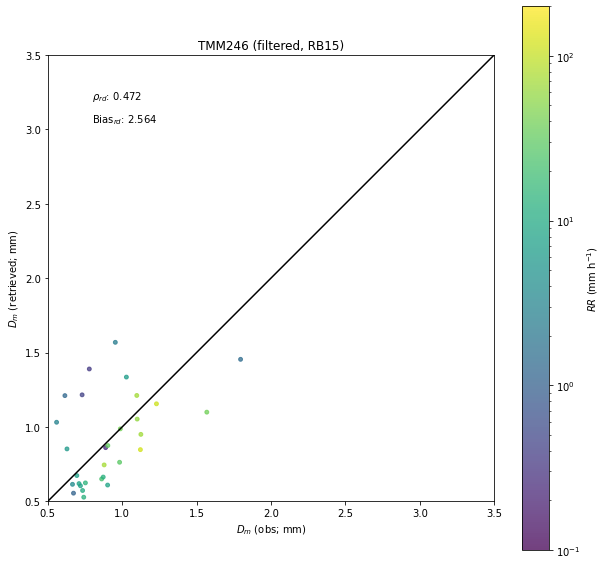

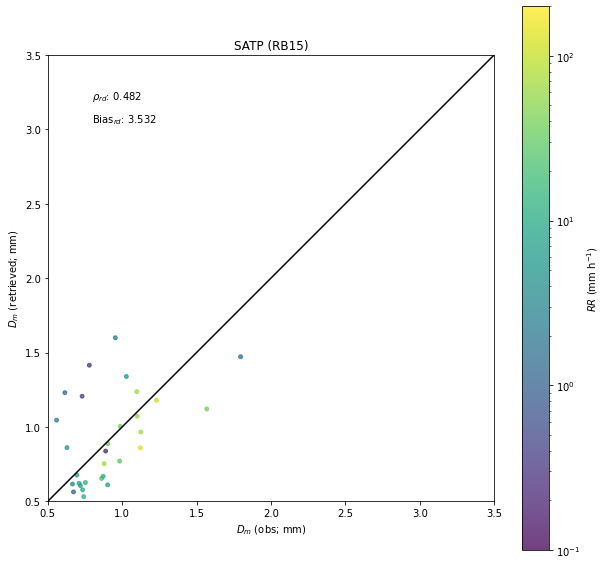

In [17]:
# sigma
varname = 'sigma'
var_obs = sigma_obs
col_field = RR_obs
axparams_var = axparams[varname]
for rad_retr_name, title in zip(retr_names, titles):
    plot_radar_retrieval_one2one(parsivel_ds, radar_name, PIPS_name, varname, rad_retr_name, var_obs, ND_tag, 
                                 col_field, title, axparams_var, deployment_name=deployment_name, 
                                 gridded_radar=gridded_radar)

In [ ]:
# Plot observed DSDs and retrieval fits for certain values of D0

# print(ND_subset)

rad_var_name = 'D0'
rad_retr_name = 'Z01'

DSD_rad_mu = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].loc[
    {radar_field_prefix: 'mu_{}'.format(rad_retr_name)}]

DSD_rad_lamda = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].loc[
    {radar_field_prefix: 'lamda_{}'.format(rad_retr_name)}] * 1000.

DSD_rad_N0 = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].loc[
    {radar_field_prefix: 'N0_{}'.format(rad_retr_name)}] * 1000.**(1. + DSD_rad_mu)

ND_rad = dsd.calc_binned_DSD_from_params(DSD_rad_N0, DSD_rad_lamda, DSD_rad_mu, ND['diameter'])
print(ND_rad)

D0_retr = parsivel_ds['{}_at_PIPS'.format(radar_prefix)].sel({
    radar_field_prefix: '{}_{}'.format(rad_var_name, rad_retr_name)
})

# print(D0_retr)

delta_D0 = D0_obs - D0_retr
delta_D0.plot()
ND_subset = ND.where(delta_D0 > 1., drop=True)
ND_rad_subset = ND_rad.where(delta_D0 > 1., drop=True)
print(ND_rad_subset)
for ND_t, ND_rad_t in zip(ND_subset, ND_rad_subset):
    ND_datetime = ND_t.coords['time'].values.astype('datetime64[us]').astype(datetime) # This is insane just to get a datetime
    ND_timestamp = ND_datetime.strftime('%Y-%m-%d: %H:%M:%S')
    fig_dsd, ax_dsd = plt.subplots()
    ax_dsd.set_title(ND_timestamp)
    ax_dsd.bar(pips.min_diameter, ND_t * 1000.0, pips.max_diameter - pips.min_diameter, 10.**2., align='edge',
               log=True, color='tan', edgecolor='k')
    ax_dsd.plot(pips.avg_diameter, ND_rad_t)
    ax_dsd.set_xlim(0.0, 9.0)
    ax_dsd.set_ylim(10.**2., 10.**8.5)
    ax_dsd.set_xlabel('D (mm)')
    ax_dsd.set_ylabel(r'N(D) $(m^{-4})$')

In [ ]:
# Plot D0 vs ZDR and compute polynomial fit
ZDR = rad_retr_dict[ZDR_field_name]

overlap = (D0_obs > 0.) & (ZDR > 0.)
D0_plt = D0_obs.where(overlap)
ZDR_plt = ZDR.where(overlap)
RR_plt = RR_obs.where(overlap)

D0_ds = xr.Dataset({'D0': D0_plt, 'ZDR': ZDR_plt, 'RR_obs': RR_plt})

D0_plt_vals = D0_plt.values
ZDR_plt_vals = ZDR_plt.values

goodindices = np.isfinite(D0_plt_vals) & np.isfinite(ZDR_plt_vals)
D0_plt_vals = D0_plt_vals[goodindices]
ZDR_plt_vals = ZDR_plt_vals[goodindices]

In [ ]:

axparams = {
    'var_lims': [[0., 4.], [0., 5.]],
    'plot_log': [False, False],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$D_0 (mm)$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(D0_ds, 'ZDR', 'D0', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_plt_vals, D0_plt_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, yy, 'k')

D0_cao = 0.0436 * (xx**3.) - 0.216 * (xx**2.) + 1.076 * xx + 0.659
ax.plot(xx, D0_cao, 'b')

In [ ]:
# Plot log(R/Zh) one-to-one plot
overlap = (RR_obs > 0.) & (RR_retr_SATP > 0.)
RR_obs_plt = RR_obs.where(overlap)
RR_retr_SATP_plt = RR_retr_SATP.where(overlap)

ZH_plt = ZH.where(ZH > 0.)
RRdZH_obs = RR_obs_plt/ZH_plt
RRdZH_retr_SATP = RR_retr_SATP_plt/ZH_plt

RRdZH_ds = xr.Dataset({'RRdZH_obs': RRdZH_obs, 'RRdZH_retr_SATP': RRdZH_retr_SATP, 'RR_obs': RR_obs_plt})

axparams = {
    'var_lims': [[-4., -1.5], [-4., -1.5]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{R/Z_H}$ (obs)',
    'label_y': r'$\log{R/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(RRdZH_ds, 'RRdZH_obs', 'RRdZH_retr_SATP', axparams)

In [ ]:
# Plot R/Zh vs. ZDR and compute polynomial fit
overlap = (RRdZH_obs > 0.) & (ZDR > 0.)
RRdZH_obs_plt = RRdZH_obs.where(overlap)
ZDR_plt = ZDR.where(overlap)
RR_obs_plt = RR_obs.where(overlap)

RRdZH_ZDR_ds = xr.Dataset({'RRdZH': RRdZH_obs_plt, 'ZDR': ZDR_plt, 'RR_obs': RR_obs_plt})

RRdZH_vals = RRdZH_obs_plt.values
log_RRdZH_vals = np.log10(RRdZH_vals)
ZDR_vals = ZDR_plt.values

goodindices = np.isfinite(log_RRdZH_vals) & np.isfinite(ZDR_vals)
log_RRdZH_vals = log_RRdZH_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a*x**3. + b*x**2. + c*x + d

popt, pcov = curve_fit(func, ZDR_vals, log_RRdZH_vals)
print(popt)

# Gives almost the same results (reversed coefficient order...)

In [ ]:

axparams = {
    'var_lims': [[0., 4.], [-4., -1.5]],
    'plot_log': [False, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$\log{R/Z_H}$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(RRdZH_ZDR_ds, 'ZDR', 'RRdZH', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_vals, log_RRdZH_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, 10.**yy, 'k')

RdZH_cao = 10.**(-0.0363 * (xx**3.) + 0.316 * (xx**2.) - 1.178 * xx - 1.964)
ax.plot(xx, RdZH_cao, 'b')

In [ ]:
# Plot W/ZH one-to-one
overlap = (W_obs > 0.) & (W_retr_SATP > 0.)
W_obs_plt = W_obs.where(overlap)
W_retr_SATP_plt = W_retr_SATP.where(overlap)
RR_obs_plt = RR_obs.where(overlap)

WdZH_obs = W_obs_plt/ZH_plt
WdZH_retr_SATP = W_retr_SATP_plt/ZH_plt
WdZH_ds = xr.Dataset({'WdZH_obs': WdZH_obs, 'WdZH_retr': WdZH_retr_SATP, 'RR_obs': RR_obs_plt})

axparams = {
    'var_lims': [[-6., -2.], [-6, -2.]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{W/Z_H}$ (obs)',
    'label_y': r'$\log{W/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(WdZH_ds, 'WdZH_obs', 'WdZH_retr', axparams)

In [ ]:
# Compute empirical fit for W/ZH vs ZDR and plot

overlap = (W_obs > 0.)
W_obs_plt = W_obs.where(overlap)
WdZH_obs = W_obs_plt/ZH_plt
overlap = (WdZH_obs > 0.) & (ZDR > 0.)
WdZH_obs = WdZH_obs.where(overlap)
ZDR_plt = ZDR.where(overlap)
RR_obs_plt = RR_obs.where(overlap)

WdZH_ZDR_ds = xr.Dataset({'WdZH': WdZH_obs, 'ZDR': ZDR_plt, 'RR_obs': RR_obs_plt})

WdZH_vals = WdZH_obs.values
log_WdZH_vals = np.log10(WdZH_vals)
ZDR_vals = ZDR_plt.values

goodindices = np.isfinite(log_WdZH_vals) & np.isfinite(ZDR_vals)
log_WdZH_vals = log_WdZH_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

In [ ]:

axparams = {
    'var_lims': [[0., 4.], [-6., -2.]],
    'plot_log': [False, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$\log{W/Z_H}$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(WdZH_ZDR_ds, 'ZDR', 'WdZH', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_vals, log_WdZH_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, 10.**yy, 'k')
WdZH_cao = 10.**(-0.0493 * (xx**3.) + 0.430 * (xx**2.) - 1.542 * xx - 3.019)
ax.plot(xx, WdZH_cao, 'b')

In [ ]:
# Plot Nt/ZH one-to-one
overlap = (Nt_obs > 0.) & (Nt_retr_SATP > 0.)
Nt_obs_plt = Nt_obs.where(overlap)
Nt_retr_SATP_plt = Nt_retr_SATP.where(overlap)
NtdZH_obs = Nt_obs_plt/ZH_plt
NtdZH_retr_SATP = Nt_retr_SATP_plt/ZH_plt
RR_obs_plt = RR_obs.where(overlap)

NtdZH_ds = xr.Dataset({'NtdZH_obs': NtdZH_obs, 'NtdZH_retr': NtdZH_retr_SATP, 'RR_obs': RR_obs_plt})

axparams = {
    'var_lims': [[-3., 2.], [-3., 2.]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{N_T/Z_H}$ (obs)',
    'label_y': r'$\log{N_T/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(NtdZH_ds, 'NtdZH_obs', 'NtdZH_retr', axparams)

In [ ]:
# Plot Z vs. ZDR
dBZ = dualpol_dict['REF']
dBZ_vals = dBZ.values
ZDR_vals = ZDR.values

goodindices = np.isfinite(dBZ_vals) & np.isfinite(ZDR_vals)
dBZ_vals = dBZ_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

ZH_ZDR_ds = xr.Dataset({'ZH': dBZ, 'ZDR': ZDR, 'RR_obs': RR_obs})

axparams = {
    'var_lims': [[0., 60.], [0., 6.]],
    'plot_log': [False, False],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{H}$ (dBZ)',
    'label_y': r'$Z_{DR}$ (dB)', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(ZH_ZDR_ds, 'ZH', 'ZDR', axparams)
ax.set_aspect('auto')
poly_coeff, poly = dsd.calc_empirical_polyfit(dBZ_vals, ZDR_vals, order=2)
print(poly_coeff)

# xx = np.linspace(0., 4.)
# yy = poly(xx)
# ax.plot(xx, 10.**yy, 'k')
# WdZH_cao = 10.**(-0.0493 * (xx**3.) + 0.430 * (xx**2.) - 1.542 * xx - 3.019)
# ax.plot(xx, WdZH_cao, 'b')